# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split 

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()
df.shape

(6362620, 11)

In [3]:
# Select a sample
sample = df.sample(100000)
print(sample.shape)
sample.head()

(100000, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
833680,41,CASH_OUT,6396.66,C273903555,0.00,0.00,C934526907,2652827.44,2659224.10,0,0
450212,19,CASH_IN,190596.54,C1998481504,10768.00,201364.54,C889673442,0.00,0.00,0,0
2810996,225,CASH_OUT,251188.38,C909148235,55792.00,0.00,C460312922,0.00,251188.38,0,0
15569,8,PAYMENT,794.18,C1527762517,1371460.55,1370666.37,M1489026763,0.00,0.00,0,0
5613458,395,CASH_OUT,482029.34,C940610186,20997.00,0.00,C1848623927,22855.78,504885.13,0,0


# Headers

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [4]:
sample.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.553280,1.815482e+05,8.353994e+05,8.570900e+05,1.088220e+06,1.216419e+06,0.001250,0.0
std,142.821752,6.397601e+05,2.877743e+06,2.913655e+06,3.247213e+06,3.598279e+06,0.035333,0.0
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,155.000000,1.342922e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,239.000000,7.534857e+04,1.413900e+04,0.000000e+00,1.328301e+05,2.137076e+05,0.000000,0.0
75%,345.000000,2.091290e+05,1.083782e+05,1.475245e+05,9.405394e+05,1.106167e+06,0.000000,0.0
max,741.000000,5.957950e+07,4.254266e+07,3.278579e+07,2.629401e+08,3.114049e+08,1.000000,0.0


In [5]:
sample.isFraud.unique()

array([0, 1], dtype=int64)

### What is the distribution of the outcome? 

Class 0: 99875
Class 1: 125
Proportion: 799.0 : 1


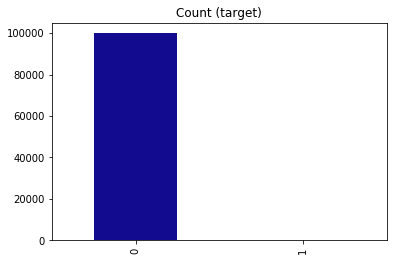

In [6]:
# Analyze the target variable
target_count = sample.isFraud.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)',color = ['#120a8f', '#06936a'])
plt.show()

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [7]:
# Verify null values
sample.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
#Drop double target
sample = sample.drop(['isFlaggedFraud'],axis=1)
sample.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [9]:
# Check duplicates
len(sample.nameOrig.unique())
df = sample.drop_duplicates(subset='nameOrig', keep="first")
df.shape

(99999, 10)

In [10]:
#Dtypes
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

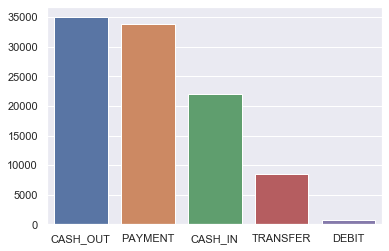

In [11]:
# counts by type of operation
sns.set()
ax = sns.barplot(x=df['type'].value_counts().index, y=df['type'].value_counts().values)
plt.show()

# Convert Categorical

In [12]:
df.columns
# # Get dummies:
categorical = ['type']

df = pd.get_dummies(df, prefix='d_', columns=categorical)
print(df.shape)
df.head(10)

(99999, 14)


,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,d__CASH_IN,d__CASH_OUT,d__DEBIT,d__PAYMENT,d__TRANSFER
833680,41,6396.66,C273903555,0.00,0.00,C934526907,2652827.44,2659224.10,0,0,1,0,0,0
450212,19,190596.54,C1998481504,10768.00,201364.54,C889673442,0.00,0.00,0,1,0,0,0,0
2810996,225,251188.38,C909148235,55792.00,0.00,C460312922,0.00,251188.38,0,0,1,0,0,0
15569,8,794.18,C1527762517,1371460.55,1370666.37,M1489026763,0.00,0.00,0,0,0,0,1,0
5613458,395,482029.34,C940610186,20997.00,0.00,C1848623927,22855.78,504885.13,0,0,1,0,0,0
3230391,250,163927.18,C1076331548,0.00,0.00,C601123469,3930200.54,4094127.72,0,0,1,0,0,0
3205696,249,61135.12,C1107553339,4112039.00,4173174.12,C1745258294,4486784.26,4425649.14,0,1,0,0,0,0
963379,44,1043.93,C2095203850,166451.99,165408.06,M160184249,0.00,0.00,0,0,0,0,1,0
1684994,159,287679.37,C1160853962,2901868.09,3189547.45,C278732228,8526811.51,8239132.14,0,1,0,0,0,0
5754031,399,1834590.95,C1521544021,0.00,0.00,C1467821593,10621467.29,12456058.24,0,0,0,0,0,1


# Time unit
- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

In [13]:
# Change the unit for days
df['step'] = df['step'].apply(lambda n: n/24).round()
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,d__CASH_IN,d__CASH_OUT,d__DEBIT,d__PAYMENT,d__TRANSFER
833680,2.0,6396.66,C273903555,0.00,0.00,C934526907,2652827.44,2659224.10,0,0,1,0,0,0
450212,1.0,190596.54,C1998481504,10768.00,201364.54,C889673442,0.00,0.00,0,1,0,0,0,0
2810996,9.0,251188.38,C909148235,55792.00,0.00,C460312922,0.00,251188.38,0,0,1,0,0,0
15569,0.0,794.18,C1527762517,1371460.55,1370666.37,M1489026763,0.00,0.00,0,0,0,0,1,0
5613458,16.0,482029.34,C940610186,20997.00,0.00,C1848623927,22855.78,504885.13,0,0,1,0,0,0


<function matplotlib.pyplot.show(*args, **kw)>

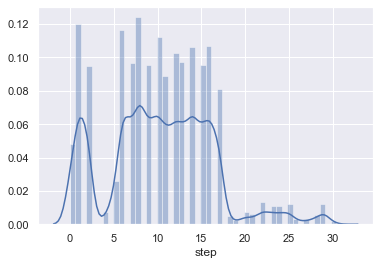

In [14]:
# Distribution of time
sns.set()
sns.distplot(df['step'])
plt.show

# This variable doesn´t have a normal distribution, i don´t know if will be good for the model??

#  What do you think will be the important features in determining the outcome?

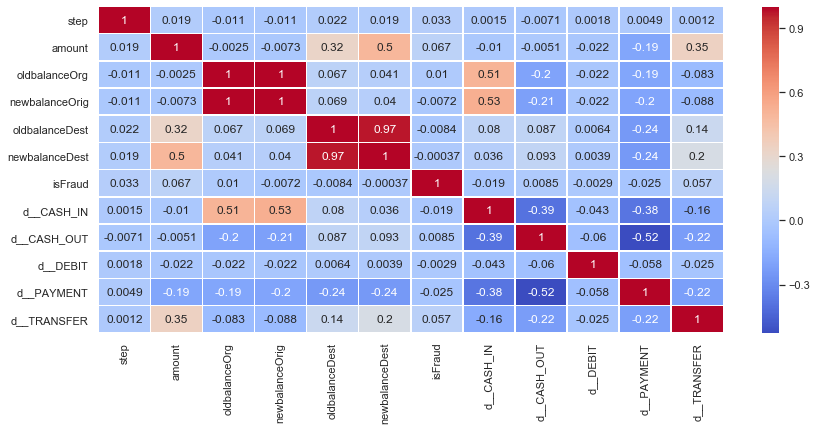

In [15]:
# Correlations
corr = df.corr()
plt.figure(figsize=(14,6))
sns.heatmap(corr, annot=True, linewidths=.5, cmap='coolwarm')

##### From this we have that the best variable for predict the response (fraud) is: Amount ad Transfer
##### We also can see that some variable are high correlated as newbalanceOrig x oldbalanceOrig e newbalanceDets x oldbalamceDest

In [16]:
# Relationship between Amount and Fraud
df.columns

Index(['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'd__CASH_IN',
       'd__CASH_OUT', 'd__DEBIT', 'd__PAYMENT', 'd__TRANSFER'],
      dtype='object')

### Run a logisitc regression classifier and evaluate its accuracy.

# Logistic Regression

In [17]:
# Choose X and Y
x = df.drop(['isFraud','nameOrig', 'nameDest' ], axis = 1, inplace=False)
y = df['isFraud']

#Split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 

predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29962
           1       0.97      0.95      0.96        38

    accuracy                           1.00     30000
   macro avg       0.99      0.97      0.98     30000
weighted avg       1.00      1.00      1.00     30000



C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
# Interpretation

### Now pick a model of your choice and evaluate its accuracy.

# KNN Classifier

In [19]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# initialize the model -> respective hyperparameters
model = KNeighborsClassifier(n_neighbors = 5)

# training 
model = model.fit(X_train, y_train)

#predictions
y_pred = model.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9993333333333333


# DecisionTrees

In [24]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier

# Model
model = DecisionTreeClassifier()

#Train
model.fit(X_train, y_train)

# Accuracy for  train
print('Accuracy for Train data is:', model.score(X_train, y_train))

# Accuracy  for test
print('Accuracy for Test data is:', model.score(X_test, y_test))

# predict the response for the test dataset
y_pred = model.predict(X_test)

# create confusion matrix
confusion_matrix(y_test, y_pred)

Accuracy for Train data is: 1.0
Accuracy for Test data is: 0.9991666666666666


array([[29946,    16],
       [    9,    29]], dtype=int64)

# SVM

In [23]:
# Support Vector Machine

from sklearn.svm import LinearSVC

#Model
model = LinearSVC()

#Training
model.fit(X_train, y_train)

# Accuracy for  train
print('Accuracy for Train data is:', model.score(X_train, y_train))

# Accuracy  for test
print('Accuracy for Test data is:', model.score(X_test, y_test))

# predict the response for the test dataset
y_pred = model.predict(X_test)

# create confusion matrix
confusion_matrix(y_test, y_pred)

Accuracy for Train data is: 0.9990857012243032
Accuracy for Test data is: 0.9992


C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[29941,    21],
       [    3,    35]], dtype=int64)

### Which model worked better and how do you know?

In [22]:
""" The model with the better final metrics is Decision Tree.
"""

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.